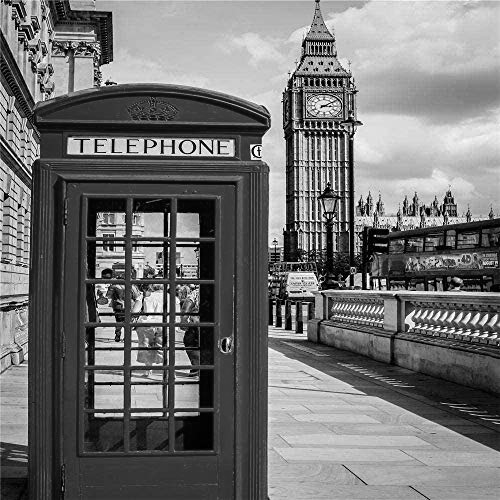

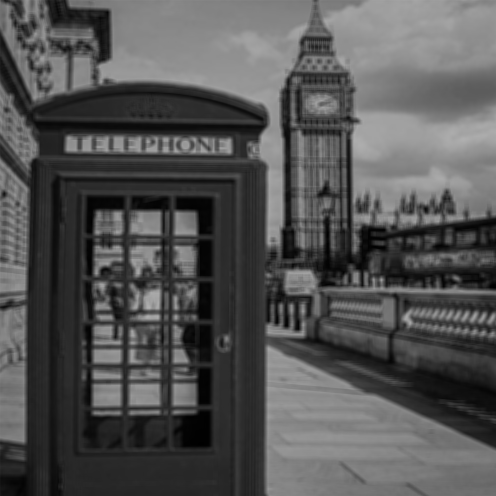

In [4]:
"""
Implementation of gaussian filter algorithm
"""
from google.colab.patches import cv2_imshow
from numba import cuda, float32
from itertools import product
from time import time
from pycuda.reduction import ReductionKernel
from math import ceil
from cv2 import COLOR_BGR2GRAY, cvtColor, imread, imshow, waitKey
from numpy import dot, exp, mgrid, pi, ravel, square, uint8, zeros
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import numpy as np
import skcuda.linalg as linalg
import skcuda.misc as misc

def gen_gaussian_kernel(k_size, sigma):
    center = k_size // 2
    x, y = mgrid[0 - center : k_size - center, 0 - center : k_size - center]
    g = 1 / (2 * pi * sigma) * exp(-(square(x) + square(y)) / (2 * square(sigma)))
    return g

def Image_reshape(image, k_size):
    height, width = image.shape[0], image.shape[1]
    # dst image height and width
    dst_height = height - k_size + 1
    dst_width = width - k_size + 1

    # im2col, turn the k_size*k_size pixels into a row and np.vstack all rows
    image_array = zeros((dst_height * dst_width, k_size * k_size))
    row = 0
    for i, j in product(range(dst_height), range(dst_width)):
        window = ravel(image[i : i + k_size, j : j + k_size])
        image_array[row, :] = window
        row += 1
    return image_array,dst_height,dst_width


def gaussian_filter(image_array, k_size, sigma,dst_height,dst_width):
    #  turn the kernel into shape(k*k, 1)
    gaussian_kernel = gen_gaussian_kernel(k_size, sigma) 
    filter_array = ravel(gaussian_kernel)
    # reshape and get the dst image
    image_gpuArray = gpuarray.to_gpu(image_array)
    filter_gpuArray = gpuarray.to_gpu(filter_array)
    ans_gpuArray = linalg.dot(image_gpuArray, filter_gpuArray)
    ans = ans_gpuArray.get()
    dst = ans.reshape(dst_height, dst_width).astype(uint8) 
    image_gpuArray.gpudata.free()
    filter_gpuArray.gpudata.free()
    return dst

def gaussian_filter_Serial(image_array, k_size, sigma,dst_height,dst_width):
    #  turn the kernel into shape(k*k, 1)
    gaussian_kernel = gen_gaussian_kernel(k_size, sigma)
    filter_array = ravel(gaussian_kernel)
    # reshape and get the dst image
    dst = dot(image_array, filter_array).reshape(dst_height, dst_width).astype(uint8)
    return dst


if __name__ == "__main__" and False:
    linalg.init()

    StimesMean=list()
    PtimesMean=list()
    StimesSTD=list()
    PtimesSTD=list()
    for i in range(1,11):
      # read original image
      img = imread(r"img{}.jpg".format(i))
      # turn image in gray scale value
      gray = cvtColor(img, COLOR_BGR2GRAY)
      Image_ravel,dst_height,dst_width = Image_reshape(gray,5)
      eachS=list()
      eachP=list()
      for _ in range(5):
        # get values with two different mask size
        
        start=time()
        gaussian3x3 = gaussian_filter_Serial(Image_ravel, 3, 5,dst_height,dst_width)
        T=time()-start
        print("Time serial:", T)
        eachS.append(T)
        start=time()
        dst= gaussian_filter(Image_ravel, 3, 5,dst_height,dst_width)
        T=time()-start
        print("Time Paralel:", T)
        eachP.append(T)
      StimesMean.append(np.mean(eachS))
      PtimesMean.append(np.mean(eachP))
      StimesSTD.append(np.std(eachS))
      PtimesSTD.append(np.std(eachP))
    print("Means S:")
    print("\n".join([str(x) for x in StimesMean]))
    print("Means P:")
    print("\n".join([str(x) for x in PtimesMean]))
    print("STD S:")
    print("\n".join([str(x) for x in StimesSTD]))
    print("STD P:")
    print("\n".join([str(x) for x in PtimesSTD]))

else:
    linalg.init()
    # read original image
    img = imread(r"img500.jpg")
    # turn image in gray scale value
    gray = cvtColor(img, COLOR_BGR2GRAY)
    Image_ravel,dst_height,dst_width = Image_reshape(gray,5)
    dst= gaussian_filter(Image_ravel, 5, 5,dst_height,dst_width)
    # show result images
    cv2_imshow(gray)
    cv2_imshow(dst)


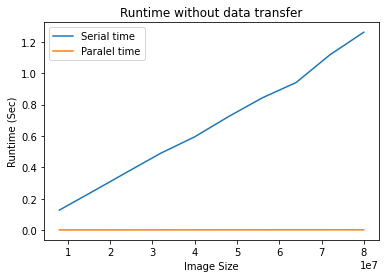

In [ ]:
size = 8000000
X=[i*size for i in range(1,11)]
import matplotlib.pyplot as plt
plt.plot(X,StimesMean, label='Serial time')
plt.plot(X,PtimesMean, label='Paralel time')
plt.legend()
plt.xlabel("Image Size")
plt.ylabel("Runtime (Sec)")
plt.title("Runtime without data transfer")
plt.show()

In [1]:
!pip install pycuda scikit-cuda opencv-python

     |████████████████████████████████| 1.7MB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 122kB 17.9MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627406 sha256=5ab48f0f33f56441353d18f3ef437875910b53b3597b40da0c880c8d787175ba
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=89028e91e61da125bd06e7ac6124c6666a4ac053fd0e346f86b07aa017cd78cb
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
import sys
from time import perf_counter 
from math import ceil
from pycuda import gpuarray
from pycuda.compiler import SourceModule
drv.init()
i = 0
gpu_device = drv.Device(i)
print('disp{}:{}'.format(i,gpu_device.name()))


disp0:Tesla T4


In [5]:
from time import sleep
while True:
  sleep(10000)

KeyboardInterrupt: ignored